In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'KTEC'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_ktec.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(857, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2021-06-09,25.150000,25.150000,24.980000,24.980000,24.740423,3.208438,0.993241,1.002242,1.004003
2021-06-10,25.080000,25.090000,25.035999,25.035999,24.795887,3.210678,0.998246,0.995886,0.998163
2021-06-11,24.990000,24.990000,24.933001,24.933001,24.693874,3.206555,0.997719,1.000000,1.000000
2021-06-14,24.933001,24.933001,24.933001,24.933001,24.693874,3.206555,1.000000,0.993061,0.995027
2021-06-15,24.809000,24.809000,24.760000,24.760000,24.522533,3.199592,0.998025,0.985784,0.985784
2021-06-16,24.408001,24.408001,24.408001,24.408001,24.173910,3.185274,1.000000,1.019174,1.016060
2021-06-17,24.799999,24.875999,24.719999,24.875999,24.637421,3.204266,1.003065,1.000965,1.000965
2021-06-18,24.900000,24.900000,24.900000,24.900000,24.661190,3.205231,1.000000,1.000964,0.996386
2021-06-21,24.809999,24.924000,24.750000,24.924000,24.684961,3.206194,1.004595,0.986720,0.986720


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2021-06-09    25.150000
2021-06-10    25.090000
2021-06-11    24.990000
2021-06-15    24.809000
2021-06-17    24.875999
                ...    
2024-10-28    14.338000
2024-10-29    14.420000
2024-10-30    14.030000
2024-10-31    13.920000
2024-11-01    13.900000
Name: high, Length: 832, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2021-06-09')  # first day of legit open/close values
SIM_START

Timestamp('2021-06-09 00:00:00')

In [7]:
len(df.index >= SIM_START)

857

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

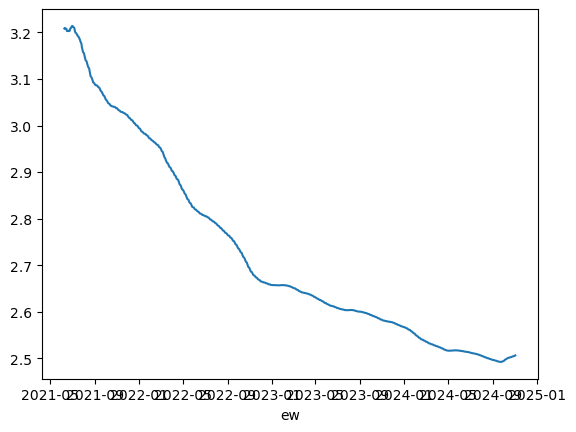

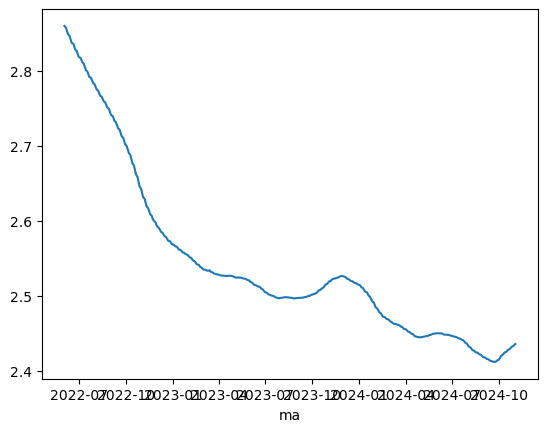

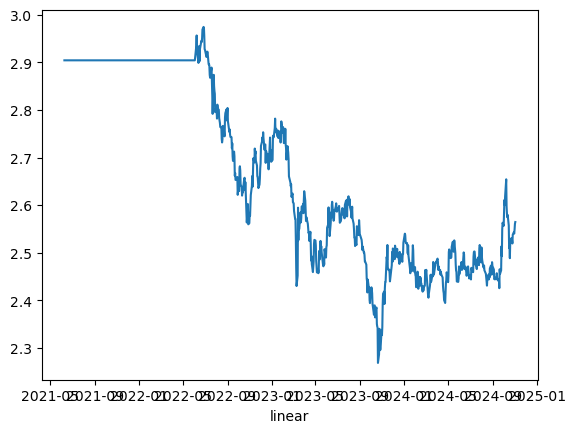

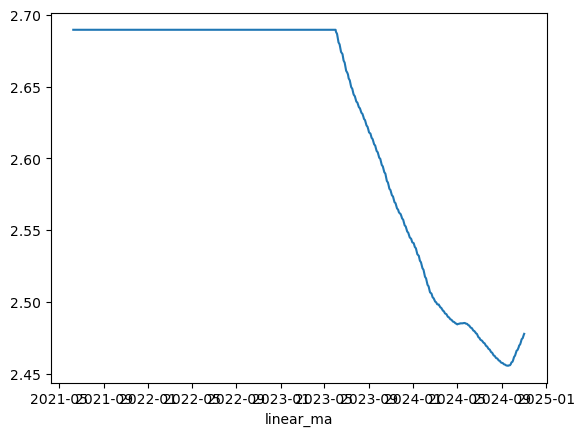

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(None, None)

Do nothing res: 0.5557706061633753
Round 1: nan
Round 2: 2.0219212595874767
New best: 2.0219212595874767
{'time_param': 176, 'method': 'linear_ma', 't': 0.4948970911138074, 'k': 3.682479230861113, 'as_q': True, 'transform_f': 'bounded_curve'}


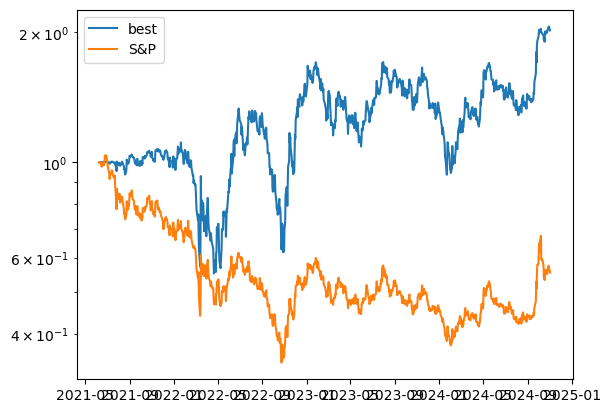

Round 3: 0.6962247366123149
Round 4: 1.8640613625887812
Round 5: 1.6066070663542122
Round 6: 1.4392768363348818
Round 7: 1.0836879434988105
Round 8: nan
Round 9: 1.8632425087818079
Round 10: 1.0408716017514346
Round 11: 1.4699813380798612
Round 12: nan
Round 13: 1.396731444063114
Round 14: 1.3221521376998904
Round 15: 2.1218818742442687
New best: 2.1218818742442687
{'time_param': 162, 'method': 'ew', 't': 0.11397408164435263, 'k': 1.1029072698427234, 'as_q': True, 'transform_f': 'bounded_curve'}


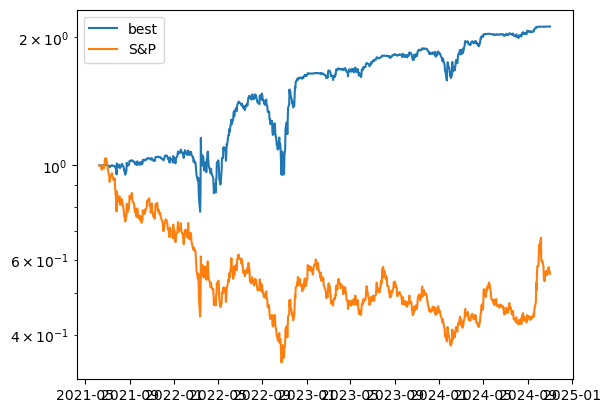

Round 16: 1.2183292630512286
Round 17: 2.991643652096986
New best: 2.991643652096986
{'time_param': 199, 'method': 'linear_ma', 't': 0.9069051277121783, 'k': 0.18780566761943493, 'as_q': True, 'transform_f': 'bounded_curve'}


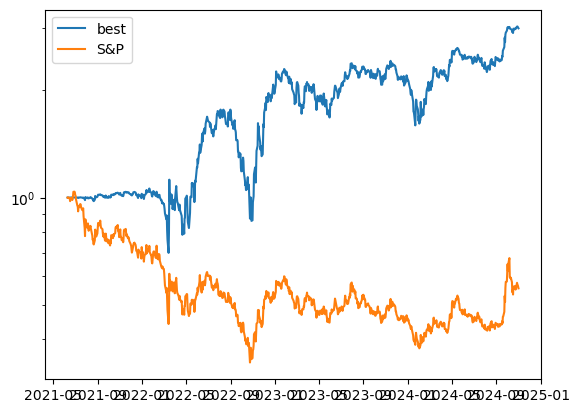

Round 18: 0.9512038882730196
Round 19: 1.3311821748562649
Round 20: 1.1767145790310085
Round 21: 1.1413416004080985
Round 22: 0.8176577081329555
Round 23: 1.267571642858868
Round 24: nan
Round 25: nan
Round 26: 0.8908400513099137
Round 27: 1.2135129512219271
Round 28: 1.653117744646522
Round 29: nan
Round 30: 1.119430327741902
Round 31: 1.2625482994795414
Round 32: 1.2370170896900357
Round 33: nan
Round 34: nan
Round 35: 1.1341728174909567
Round 36: 0.7949201113873527
Round 37: 1.2969453012259982
Round 38: 1.3725612893660173
Round 39: nan
Round 40: nan
Round 41: 1.397959317644583
Round 42: 2.029599666325606
Round 43: 1.221298736709256
Round 44: 0.7520526475355328
Round 45: 1.392496009027814
Round 46: 1.2487171485204822
Round 47: 2.133722276554765
Round 48: 1.2969766871284019
Round 49: nan
Round 50: 1.0718690939372468
Round 51: 1.2483124269941355
Round 52: 0.767726850708748
Round 53: 1.8296654697081658
Round 54: 1.199229249858188
Round 55: nan
Round 56: 2.291674022864111
Round 57: 1.715

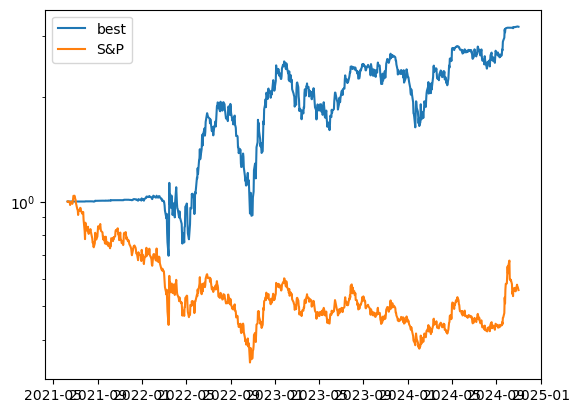

Round 154: 1.3729931390862338
Round 155: 0.9164696548722097
Round 156: 0.8143168272702817
Round 157: 2.170899284834187
Round 158: 2.5593729945526587
Round 159: 2.226236823797762
Round 160: nan
Round 161: 1.364654587531498
Round 162: 1.6587803835235375
Round 163: nan
Round 164: 1.3178624669109125
Round 165: 1.4053478580125605
Round 166: 1.1367951009582837
Round 167: 1.4412131528664864
Round 168: 1.342010915973996
Round 169: 1.2902217072919124
Round 170: nan
Round 171: 1.193309683502865
Round 172: 1.4886008134001611
Round 173: 2.4541903040820117
Round 174: 2.894858153869287
Round 175: 1.6035038407550317
Round 176: nan
Round 177: nan
Round 178: 1.1746582934798329
Round 179: 0.8928741608285062
Round 180: 1.4934661076706717
Round 181: 1.5192084272281345
Round 182: nan
Round 183: nan
Round 184: 1.1876243348187532
Round 185: 1.254890173569484
Round 186: 3.701302241315344
New best: 3.701302241315344
{'time_param': 209, 'method': 'linear_ma', 't': 0.21831806242496532, 'k': 9.139766479288786, 'a

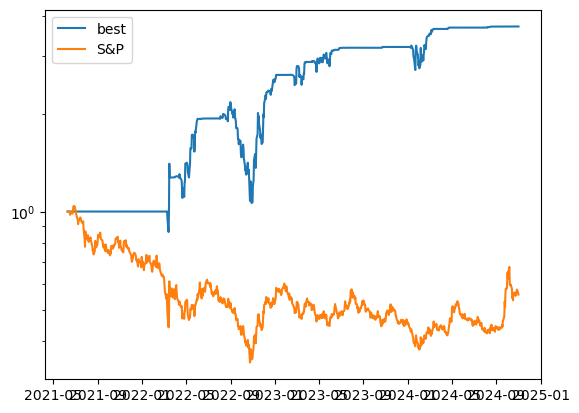

Round 187: 0.8105532074397039
Round 188: 1.1426175370416027
Round 189: nan
Round 190: 1.360957426743407
Round 191: 1.0172031729311368
Round 192: nan
Round 193: 1.1520653356722959
Round 194: nan
Round 195: 0.8598893564824737
Round 196: 1.3083344634200442
Round 197: 1.397584347498283
Round 198: 0.6974119955227402
Round 199: nan
Round 200: 1.4224728519148466


In [18]:
best_out, params_out = run_simulation(
    df.copy(), iters=200, current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 0.5557706061633753
Round 1: 1.8054718585088558
Round 2: 2.1273294583013067
Round 3: 4.96824669344777
New best: 4.96824669344777
{'time_param': 221, 'method': 'linear_ma', 't': 0.5509715886916193, 'k': 8.950475432401305, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


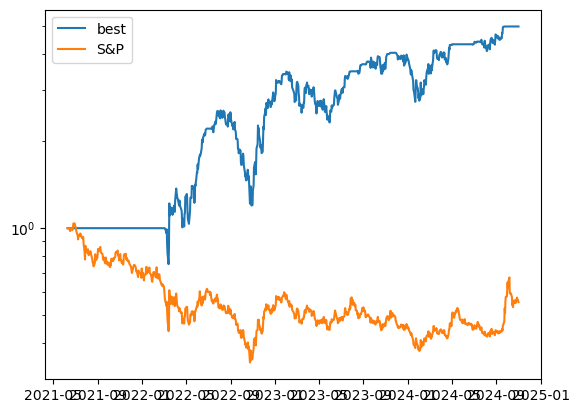

Round 4: 0.7409320228100609
Round 5: 1.906715703282797
Round 6: 1.3434290719944981
Round 7: 4.145434279288687
Round 8: 1.8060027741152704
Round 9: 1.7361295003807922
Round 10: 0.8291052786172872
Round 11: 5.035007944546331
New best: 5.035007944546331
{'time_param': 224, 'method': 'linear_ma', 't': 0.5023091059564145, 'k': 8.901035491983286, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


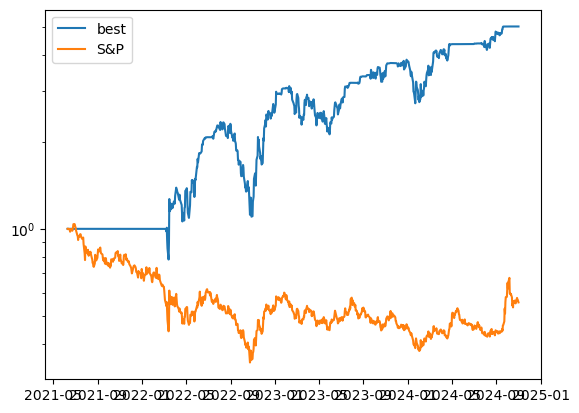

Round 12: 3.9384994158698365
Round 13: 5.09288759196121
New best: 5.09288759196121
{'time_param': 216, 'method': 'linear_ma', 't': 0.49293858704204935, 'k': 8.701545393483869, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


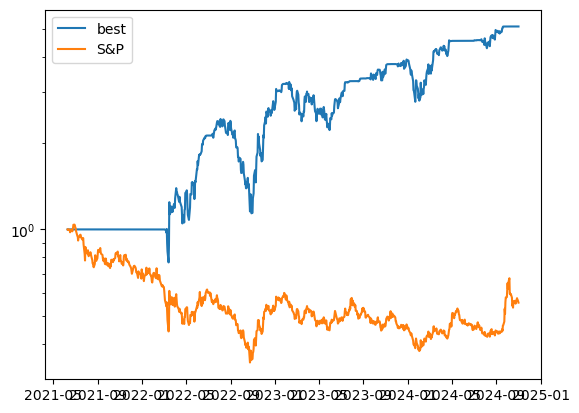

Round 14: 0.8502715482877529
Round 15: 2.2167837630219247
Round 16: 4.059239891374242
Round 17: 1.0923538789494704
Round 18: 4.851501155623301
Round 19: 4.261626838253356
Round 20: 3.3158636628287947
Round 21: 2.9908467037057753
Round 22: 1.711552679693616
Round 23: 3.7401712129082525
Round 24: 2.804791408499416
Round 25: 4.950008351421838

Factor: 1.03125
Do nothing res: 0.5557706061633753
Round 1: 1.067854974559193
Round 2: 4.802124138243433
Round 3: 2.3463799321907843
Round 4: 1.4531881945667522
Round 5: 5.129383301960269
New best: 5.129383301960269
{'time_param': 211, 'method': 'linear_ma', 't': 0.4813636539801758, 'k': 8.785497443104473, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


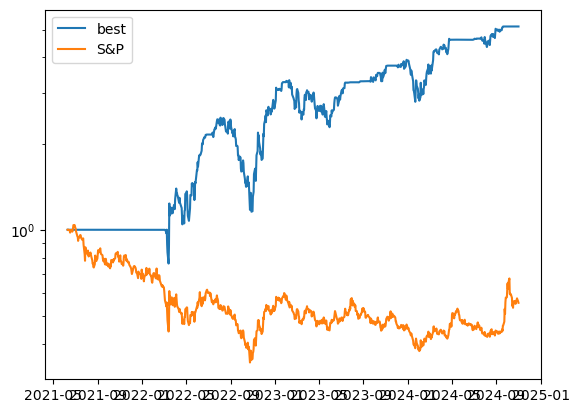

Round 6: 3.9672130727871475
Round 7: 2.507047599831632
Round 8: 1.0915739555676345
Round 9: 0.7409695904994793
Round 10: 1.3916042359813143
Round 11: 3.5661856677924066
Round 12: 1.0929360010900793
Round 13: 3.62374961594927
Round 14: 3.5639810260832347
Round 15: 4.206149697872693
Round 16: 0.7409776502471312
Round 17: 3.678896986754044
Round 18: 3.931903074215733
Round 19: 0.7409409648247878
Round 20: 3.601643575213852
Round 21: 2.605727075018439
Round 22: 3.9512208245992557
Round 23: 3.344246984540745
Round 24: 4.0301880199738065
Round 25: 4.849610179896244

Factor: 1.015625
Do nothing res: 0.5557706061633753
Round 1: 5.188509294509032
New best: 5.188509294509032
{'time_param': 211, 'method': 'linear_ma', 't': 0.4917977789180788, 'k': 8.758073364734017, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


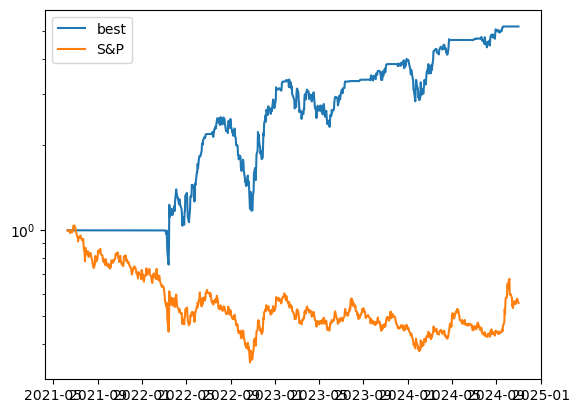

Round 2: 5.104007627147976
Round 3: 2.762765895056274
Round 4: 0.7410020694787459
Round 5: 0.7409996602848311
Round 6: 4.8496955644304975
Round 7: 4.271684669964703
Round 8: 2.5471832466434443
Round 9: 5.268633831296153
New best: 5.268633831296153
{'time_param': 207, 'method': 'linear_ma', 't': 0.48835681756166377, 'k': 8.64562796466855, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


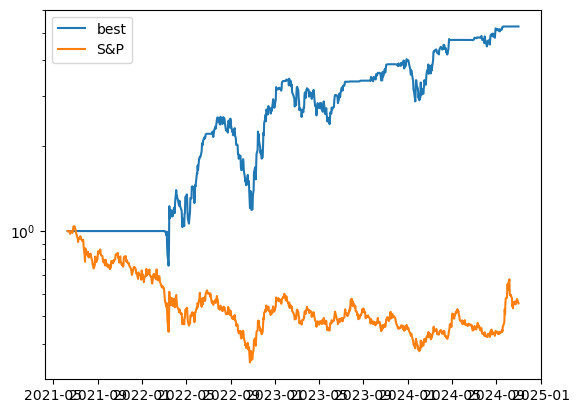

Round 10: 0.7410228773872675
Round 11: 3.5736893211092435
Round 12: 3.2401210461999237
Round 13: 1.0926602947655986
Round 14: 5.002462085178831
Round 15: 1.8483993600707047
Round 16: 0.7410075035199845
Round 17: 3.703719847639309
Round 18: 4.98831476659624
Round 19: 5.340340983613645
New best: 5.340340983613645
{'time_param': 208, 'method': 'linear_ma', 't': 0.5123358274144233, 'k': 8.689187359727516, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


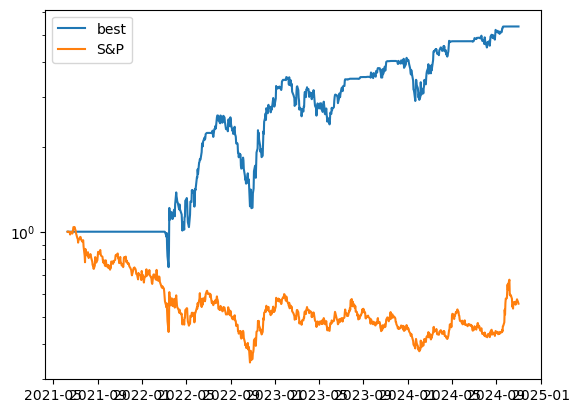

Round 20: 3.7596272844323524
Round 21: 4.981534592290118
Round 22: 1.093227885180469
Round 23: 5.324689130127066
Round 24: 4.857501054053392
Round 25: 4.170549865423048

Factor: 1.0078125
Do nothing res: 0.5557706061633753
Round 1: 2.1439974515256224
Round 2: 5.307112494154968
Round 3: 0.815101935147234
Round 4: 3.4480470648746997
Round 5: 1.5350123069879273
Round 6: 2.7139662313009234
Round 7: 1.0926134753985524
Round 8: 5.273649934039596
Round 9: 1.9585836198394402
Round 10: 0.7410053523923447
Round 11: 4.815479238727699
Round 12: 2.6281711993341794
Round 13: 3.328986125264699
Round 14: 5.1889674820680005
Round 15: 3.0121106471848167
Round 16: 1.6604074462578944
Round 17: 0.8238473476384836
Round 18: 0.7409953764737035
Round 19: 4.223166522066375
Round 20: 0.741004885966032
Round 21: 1.4215053164572833
Round 22: 4.026892033846486
Round 23: 1.0929660476543306
Round 24: 1.6751653262312176
Round 25: 3.908824830699269



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

1.7453696677938169e-06

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.8271028037383178

In [24]:
params_out

{'time_param': 208,
 'method': 'linear_ma',
 't': 0.5123358274144233,
 'k': 8.689187359727516,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


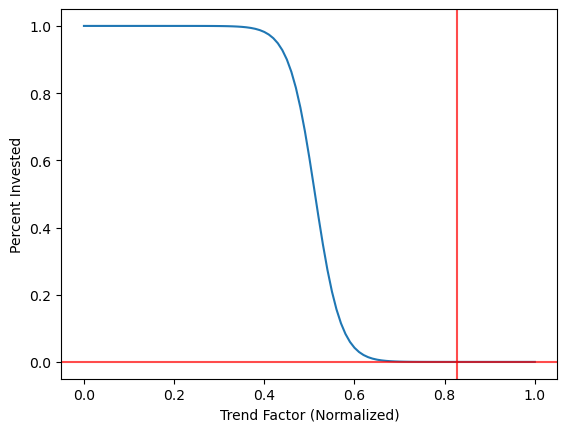

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

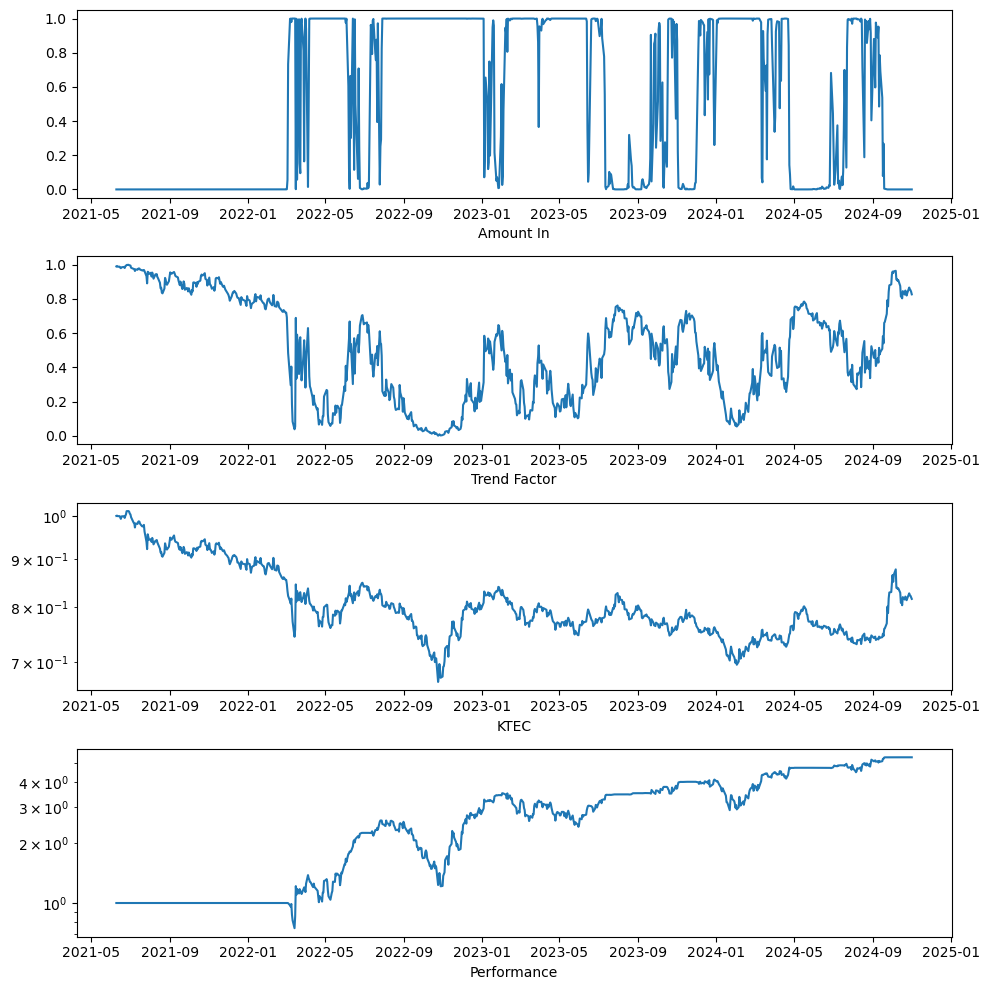

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('KTEC')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('KTEC')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

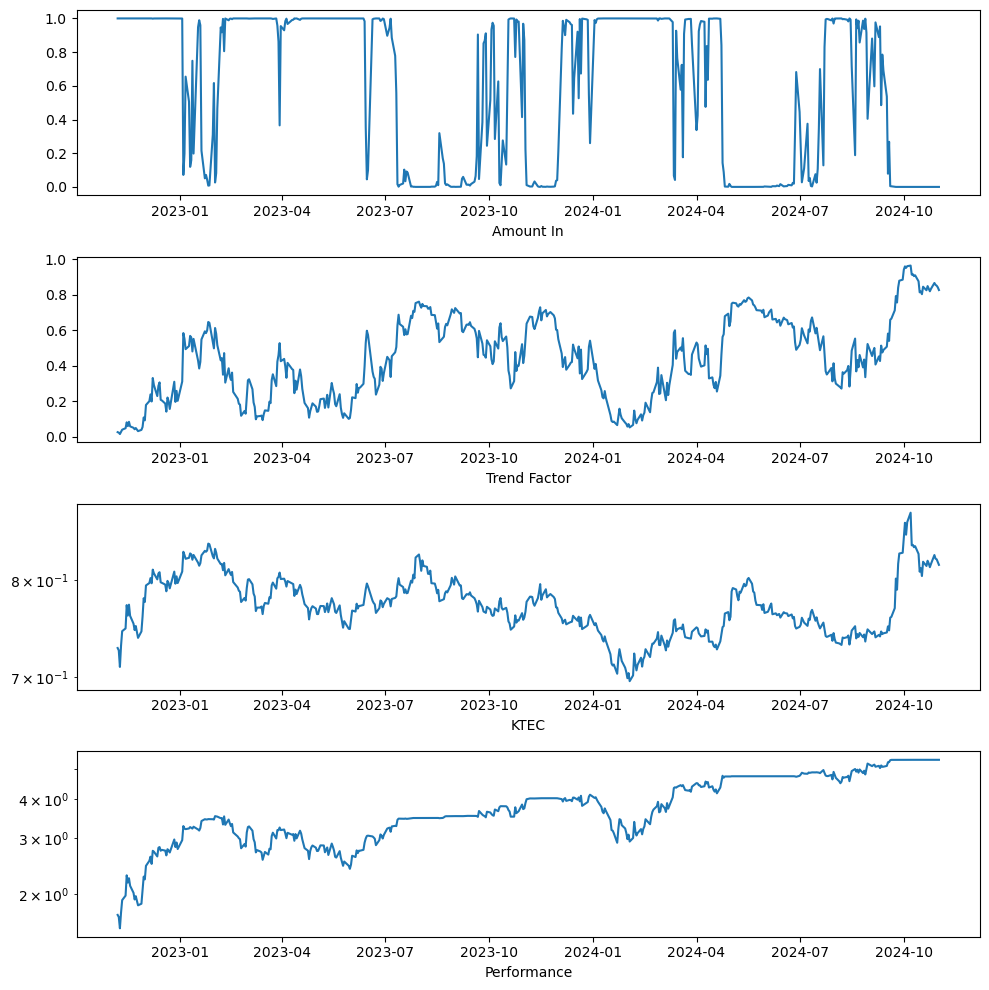

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('KTEC')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(24.74042320251465, 3.428, 13.75)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.6302079070835445

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['ktec'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1195809596024326, 1.0], 'nas': [1.2400991798626717, 1.0], 'rus': [1.289635015313776, 1.0], 'jpxn': [1.0738414738575615, 0.9804], 'ktec': [1.6302079070835445, 0.0], 'emb': [1.075625264258124, 1.0], 'gdx': [1.3583771630868045, 0.1098], 'dia': [1.2150917603746183, 1.0], 'nfty': [1.269027126456216, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(5.340340983613645,
 {'time_param': 208,
  'method': 'linear_ma',
  't': 0.5123358274144233,
  'k': 8.689187359727516,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})